In [3]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from datetime import date
from datetime import datetime

from scipy.sparse import csr_matrix

In [4]:
df = pd.read_csv('edzd_trans_data.csv')
# print type of each column
for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)

Type of column transaction_id is object
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is object
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [5]:
# change the type of product_id to int and number them from 1 to number of different product_ids
df['product_id'] = df['product_id'].astype('category')
df['product_id'] = df['product_id'].cat.codes

# change the type of transaction_id to int and number them from 1 to number of different transaction_ids
df['transaction_id'] = df['transaction_id'].astype('category')
df['transaction_id'] = df['transaction_id'].cat.codes

print(df.head())
print(df.shape)

   transaction_id       sales_datetime customer_id  product_id  quantity  \
0          680577  2011-01-01 09:04:00          -1         157       1.0   
1         3148654  2011-01-01 09:04:00          -1       43930       1.0   
2         3148654  2011-01-01 09:04:00          -1       12666       1.0   
3          651357  2011-01-01 09:08:00          -1       39576       1.0   
4          651357  2011-01-01 09:08:00          -1       44343       1.0   

   price  category_id  parent_id  store_id  department_id  salesperson_id  
0   13.5          208         29        18              2             108  
1    6.5          179         30        17              2             108  
2    6.5          179         30        17              2             108  
3   10.5          175         29         1              2             108  
4   17.5          208         29         1              2             108  
(8159536, 11)


In [6]:
# Create a sparse matrix of the data group it by transaction_id and product_id
my_basket = csr_matrix(
    (df['quantity'], (df['transaction_id'], df['product_id'])))

# change all positive values to 1 and all negative values to 0
my_basket.data = np.where(my_basket.data > 0, 1, 0)

# Create a dataframe of the sparse matrix
my_basket = pd.DataFrame.sparse.from_spmatrix(my_basket)
my_basket_sets = my_basket

# change all values to boolean
my_basket_sets = my_basket_sets.astype(bool)

print(my_basket_sets.head())

/tmp/ipykernel_32418/2710132471.py:13: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  my_basket_sets = my_basket_sets.astype(bool)


   0      1      2      3      4      5      6      7      8      9      ...  \
0  False  False  False  False  False  False  False  False  False  False  ...   
1  False  False  False  False  False  False  False  False  False  False  ...   
2  False  False  False  False  False  False  False  False  False  False  ...   
3  False  False  False  False  False  False  False  False  False  False  ...   
4  False  False  False  False  False  False  False  False  False  False  ...   

   94092  94093  94094  94095  94096  94097  94098  94099  94100  94101  
0  False  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  False  False  

[5 rows x 94102 columns]


## min support

In [9]:
# get date from string
def get_date(string):
    return datetime.strptime(string, '%Y-%m-%d %H:%M:%S').date()

# number of days over which data was collected
delta = get_date(max(df['sales_datetime'])) - get_date(min(df['sales_datetime']))
days_count = delta.days

# number of transactions in our data
transactions_count = df.shape[0]

print("The transactions are from " + str(days_count) + " days.")
print("There are " + str(transactions_count) + " transactions.")

print("5 960 transactions a day, on average.")


The transactions are from 1369 days.
There are 8159536 transactions.
5 960 transactions a day, on average.


In [12]:
# Defining minimal support. How to do that?

# frequent = appears at least in 20 transactions in a day
# jaka minimalna wartość dla apriori?
min_support = 19 * days_count / transactions_count

my_frequent_itemsets = apriori(my_basket_sets, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

there are 43 frequent itemsets


In [20]:
min_support = 3 * days_count / transactions_count
my_frequent_itemsets = fpgrowth(my_basket_sets, min_support=min_support)

# kod generujący listę frequent_itemsets_sizes. Zakomentowany, bo długo się robi.
#frequent_itemsets_sizes = [0]

#for i in range(1, 31):
#    min_support = i * days_count / transactions_count
#    my_frequent_itemsets = fpgrowth(my_basket_sets, min_support=min_support)
#    print("there are " + str(my_frequent_itemsets.shape[0]) +
#          " frequent itemsets for support: " + str(i) + " transactions a day.")
#    frequent_itemsets_sizes.append(my_frequent_itemsets.shape[0])
    
#print(frequent_itemsets_sizes)

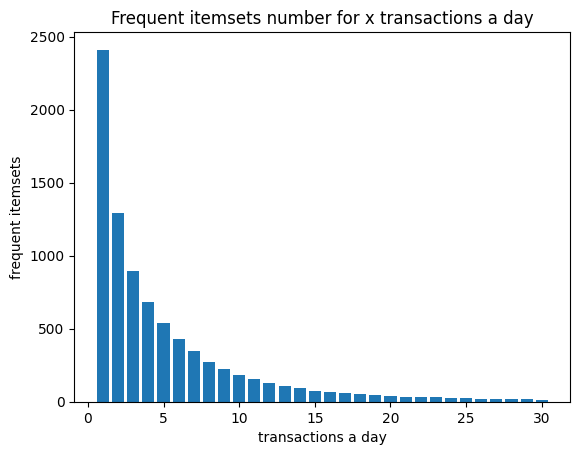

In [18]:
# Frequent itemsets number for x transactions a day plot

import matplotlib.pyplot as plt

x_axis = range(1,31)
y_axis = [2410, 1290, 893, 686, 542, 429, 348, 274, 224, 184, 156, 129, 105, 91, 75, 66, 59, 53, 43, 37, 35, 33, 30, 28, 26, 22, 21, 18, 16, 13]

plt.bar(x_axis, y_axis)
plt.title('Frequent itemsets number for x transactions a day')
plt.xlabel('transactions a day')
plt.ylabel('frequent itemsets')
plt.show()

## different way of getting the sparse matrix - by using TransactionEncoder

In [11]:
df_grouped = df.groupby('transaction_id')['product_id'].apply(list)
dataset = df_grouped.tolist()
print(dataset[:5])

[[1471, 42219, 13191, 15774, 48230, 91326, 84341], [87313, 1352, 55561, 56208, 30757, 11143], [59733], [51302, 41787, 69481, 44343], [64116]]


In [ ]:
te = TransactionEncoder()
fitted = te.fit(dataset)
te_ary = fitted.transform(dataset, sparse=True)
my_basket = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
print(my_basket.head())

In [ ]:
# frequent = appears at least in 30 transactions in a day
min_support = 30 * days_count / transactions_count

my_frequent_itemsets = apriori(my_basket, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

## association rules

In [ ]:
# frequent = appears at least in 3 transactions in a day
min_support = 3 * days_count / transactions_count
my_frequent_itemsets = fpgrowth(my_basket, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

In [16]:
#only confidence

my_association_rules = association_rules(my_frequent_itemsets, metric="confidence", min_threshold=0.7)

print("there are " + str(my_association_rules.shape[0]) + " association rules")
print(my_association_rules)
# 10 rules for 893 frequent itemsets

there are 10 association rules
      antecedents     consequents  antecedent support  consequent support  \
0         (43990)         (76545)            0.000951            0.001194   
1         (59576)         (76545)            0.000756            0.001194   
2         (59576)         (43990)            0.000756            0.000951   
3  (59576, 76545)         (43990)            0.000671            0.000951   
4  (59576, 43990)         (76545)            0.000625            0.001194   
5  (76545, 43990)         (59576)            0.000724            0.000756   
6         (59576)  (76545, 43990)            0.000756            0.000724   
7         (51138)         (28707)            0.000621            0.005530   
8         (69718)         (28707)            0.000648            0.005530   
9         (38102)         (11113)            0.000593            0.003726   

    support  confidence         lift  leverage  conviction  
0  0.000724    0.760779   636.920354  0.000722    4.175239  

In [17]:
#only lift

my_association_rules = association_rules(my_frequent_itemsets, metric="lift", min_threshold=1.2)

print("there are " + str(my_association_rules.shape[0]) + " association rules")
print(my_association_rules)
# 100 rules for 893 frequent itemsets

there are 100 association rules
   antecedents consequents  antecedent support  consequent support   support  \
0      (87313)     (67214)            0.011430            0.005244  0.000528   
1      (67214)     (87313)            0.005244            0.011430  0.000528   
2      (61987)     (28829)            0.004918            0.013549  0.000944   
3      (28829)     (61987)            0.013549            0.004918  0.000944   
4       (6427)     (28829)            0.003664            0.013549  0.000971   
..         ...         ...                 ...                 ...       ...   
95     (14021)     (71292)            0.001490            0.001545  0.000527   
96     (43946)      (6014)            0.001978            0.001167  0.000533   
97      (6014)     (43946)            0.001167            0.001978  0.000533   
98     (11113)     (38102)            0.003726            0.000593  0.000593   
99     (38102)     (11113)            0.000593            0.003726  0.000593   

    con

In [15]:
# antecedent_len >= 2, lift & confidence
 
my_association_rules["antecedent_len"] = my_association_rules["antecedents"].apply(lambda x: len(x))

my_association_rules = my_association_rules[ (my_association_rules['antecedent_len'] >= 2) &
                                             (my_association_rules['confidence'] > 0.75) &
                                             (my_association_rules['lift'] > 1.2) ]

print(my_association_rules)

       antecedents consequents  antecedent support  consequent support  \
30  (59576, 76545)     (43990)            0.000671            0.000951   
31  (59576, 43990)     (76545)            0.000625            0.001194   
32  (76545, 43990)     (59576)            0.000724            0.000756   

     support  confidence         lift  leverage  conviction  antecedent_len  
30  0.000593    0.883629   929.085338  0.000592    8.585048               2  
31  0.000593    0.948349   793.953042  0.000592   19.337530               2  
32  0.000593    0.819013  1083.210621  0.000592    5.521075               2  


In [18]:
my_association_rules["antecedent_len"] = my_association_rules["antecedents"].apply(lambda x: len(x))

my_association_rules = my_association_rules[ (my_association_rules['antecedent_len'] >= 1) &
                                             (my_association_rules['confidence'] > 0.75) &
                                             (my_association_rules['lift'] > 1.2) ]

print(my_association_rules)

       antecedents     consequents  antecedent support  consequent support  \
25         (43990)         (76545)            0.000951            0.001194   
26         (59576)         (76545)            0.000756            0.001194   
28         (59576)         (43990)            0.000756            0.000951   
30  (59576, 76545)         (43990)            0.000671            0.000951   
31  (59576, 43990)         (76545)            0.000625            0.001194   
32  (76545, 43990)         (59576)            0.000724            0.000756   
33         (59576)  (76545, 43990)            0.000756            0.000724   
60         (51138)         (28707)            0.000621            0.005530   
81         (69718)         (28707)            0.000648            0.005530   
99         (38102)         (11113)            0.000593            0.003726   

     support  confidence         lift  leverage  conviction  antecedent_len  
25  0.000724    0.760779   636.920354  0.000722    4.175239    

In [ ]:
# jakie warto dać wykresuchy?

# ile dostajemy frequent item sets w zależności od min support?
# to byłby taki wykres + dyskusja o tym jaki support ma sens względem rozmiaru danych i okresu czasu, z którego są dane

# ile dostajemy association rules w zależności od confidence, support, lift? (3 wykresy wow)


# Customer analysis